In [2]:
from dataclasses import dataclass, field
from typing import Optional, Dict, Union, Literal

import torch
from gpytorch.constraints import Interval, GreaterThan, Positive
from gpytorch.kernels import RBFKernel, MaternKernel, ScaleKernel
from gpytorch.priors import GammaPrior, Prior
from torch.nn.functional import softplus


@dataclass
class Priors:
    lengthscale_prior: Prior = field(default_factory=lambda: GammaPrior(3.0, 0.5))
    outputscale_prior: Prior = field(default_factory=lambda: GammaPrior(3.0, 0.5))
    noise_prior: Prior = field(default_factory=lambda: GammaPrior(1.1, 0.05))
    df_prior: Prior = field(default_factory=lambda: GammaPrior(2.0, 0.15))

@dataclass
class Constraints:
    lengthscale_constraint: Interval = field(default_factory=Positive)
    outputscale_constraint: Interval = field(default_factory=Positive)
    noise_constraint: Interval = field(default_factory=Positive)
    df_constraint: Interval = field(default_factory=lambda: GreaterThan(2 + 1e-4))

@dataclass
class Device:
    device: torch.device = torch.device("cpu")
    dtype: torch.dtype = torch.float


@dataclass
class ModelConfig:
    ard_num_dims: Optional[int]  # Changed to Optional[int]
    kernel_type: Literal["rbf", "matern32", "matern52"] = "rbf"
    priors: Priors = field(default_factory=Priors)
    constraints: Constraints = field(default_factory=Constraints)
    device: Device = field(default_factory=Device)
    trained_params: Optional[Dict[str, Union[float, torch.Tensor]]] = None


def kronDelta(X, Xstar):
    return (X.unsqueeze(1) == Xstar.unsqueeze(0)).all(dim=2).float()


# ======================
# Kernel Creation Function
# ======================

def create_kernel(config: ModelConfig):
    """
    Creates the kernel for the GP or TP model based on the specified kernel type.
    """
    # Select base kernel based on kernel_type
    if config.kernel_type == "rbf":
        base_kernel = RBFKernel(
            ard_num_dims=config.ard_num_dims,
            lengthscale_prior=config.priors.lengthscale_prior
            if not (config.trained_params and "lengthscale" in config.trained_params)
            else None,
            lengthscale_constraint=config.constraints.lengthscale_constraint,
        )
    elif config.kernel_type == "matern32":
        base_kernel = MaternKernel(
            nu=1.5,
            ard_num_dims=config.ard_num_dims,
            lengthscale_prior=config.priors.lengthscale_prior
            if not (config.trained_params and "lengthscale" in config.trained_params)
            else None,
            lengthscale_constraint=config.constraints.lengthscale_constraint,
        )
    elif config.kernel_type == "matern52":
        base_kernel = MaternKernel(
            nu=2.5,
            ard_num_dims=config.ard_num_dims,
            lengthscale_prior=config.priors.lengthscale_prior
            if not (config.trained_params and "lengthscale" in config.trained_params)
            else None,
            lengthscale_constraint=config.constraints.lengthscale_constraint,
        )
    else:
        raise ValueError("Invalid kernel type specified. Choose from 'rbf', 'matern32', or 'matern52'.")

    # Set trained lengthscale if available
    if config.trained_params and "lengthscale" in config.trained_params:
        lengthscale_value = torch.tensor(config.trained_params["lengthscale"]).to(
            device=config.device.device, dtype=config.device.dtype
        )
        # Adjust shape based on ard_num_dims
        if config.ard_num_dims is not None:
            # ARD case: lengthscale is of shape (1, ard_num_dims, 1)
            lengthscale_value = lengthscale_value.view(1, config.ard_num_dims, 1)
        else:
            # Non-ARD case: lengthscale is scalar
            lengthscale_value = lengthscale_value
        base_kernel.initialize(lengthscale=lengthscale_value)

    # Wrap the base kernel with ScaleKernel
    kernel = ScaleKernel(
        base_kernel=base_kernel,
        outputscale_prior=config.priors.outputscale_prior
        if not (config.trained_params and "outputscale" in config.trained_params)
        else None,
        outputscale_constraint=config.constraints.outputscale_constraint,
    )

    # Set trained outputscale if available
    if config.trained_params and "outputscale" in config.trained_params:
        outputscale_value = torch.tensor(config.trained_params["outputscale"]).to(
            device=config.device.device, dtype=config.device.dtype
        )
        kernel.initialize(outputscale=outputscale_value)

    return kernel


# ======================
# CovFunc Class with Noise Handling using kronDelta
# ======================

class CovarianceFunction:
    def __init__(self, config: ModelConfig):
        """
        Covariance function wrapper with noise handling for Gaussian Process kernels.
        
        Parameters
        ----------
        config : ModelConfig
            Configuration object that includes kernel type, priors, constraints, and noise settings.
        """
        self.config = config
        self.kernel = create_kernel(config)
        
        # Set noise level as a trainable parameter
        if config.trained_params and "noise" in config.trained_params:
            self.raw_noise = torch.nn.Parameter(
                torch.tensor(config.trained_params["noise"], device=config.device.device, dtype=config.device.dtype)
            )
        else:
            # Initialize with the mean of the noise prior if not specified in trained_params
            self.raw_noise = torch.nn.Parameter(
                torch.tensor(config.priors.noise_prior.mean, device=config.device.device, dtype=config.device.dtype)
            )

    @property
    def noise(self):
        """Apply softplus to ensure noise is positive."""
        return softplus(self.raw_noise)
    
    def get_params(self) -> Dict[str, torch.Tensor]:
        """
        Returns a dictionary of trainable parameters for optimization.

        Returns
        -------
        list
            List of trainable parameters (raw lengthscale, outputscale, noise).
        """
        return {
            "lengthscale": self.kernel.base_kernel.raw_lengthscale,
            "outputscale": self.kernel.raw_outputscale,
            "noise": self.raw_noise
        }

    def K(self, X, Xstar):
        """
        Computes the covariance matrix including noise using kronDelta.

        Parameters
        ----------
        X : torch.Tensor, shape=(n_samples, n_features)
            Input data.
        Xstar : torch.Tensor, shape=(m_samples, n_features)
            Input data for prediction.

        Returns
        -------
        torch.Tensor
            Covariance matrix with noise component.
        """

        # Kernel matrix computation
        K = self.kernel(X, Xstar).evaluate()
        
        # Add observation noise
        K += self.noise * kronDelta(X, Xstar)
        
        return K

# ======================
# Sample Usage
# ======================

# Config with Specific Kernel Type and Initial Values for Lengthscale, Outputscale, and Noise
config = ModelConfig(
    ard_num_dims=None,  # Set to None for non-ARD (scalar lengthscale)
    kernel_type="matern32",  # "rbf", "matern32", or "matern52"
    trained_params={"lengthscale": 1.0, "outputscale": 1.0, "noise": 0.1}
)

cov_func = CovarianceFunction(config)

# Example data
X = torch.tensor([[1.0], [2.0], [3.0]])
K = cov_func.K(X, X)  # X and Xstar are the same, so noise is added

# ======================
# Print Results
# ======================

print("Covariance matrix with noise:\n", K)
print(f"kernel: \n{cov_func.kernel}\n")
print(f"lengthscale: {cov_func.kernel.base_kernel.lengthscale.item()}")
print(f"outputscale: {cov_func.kernel.outputscale.item()}")


Covariance matrix with noise:
 tensor([[1.7444, 0.4834, 0.1397],
        [0.4834, 1.7444, 0.4834],
        [0.1397, 0.4834, 1.7444]], grad_fn=<AddBackward0>)
kernel: 
ScaleKernel(
  (base_kernel): MaternKernel(
    (raw_lengthscale_constraint): Positive()
  )
  (raw_outputscale_constraint): Positive()
)

lengthscale: 1.0
outputscale: 1.0


In [12]:
from typing import Dict
import torch
import torch.optim as optim


class tStudentProcess:
    def __init__(self, config, optimize=False, mprior=0.0):
        """
        t-Student Process regressor class using PyTorch.

        Parameters
        ----------
        covfunc : instance of covariance function class
            Covariance function implementing K(X, Xstar).
        nu : float
            Degrees of freedom (>2.0).
        optimize : bool
            Whether to perform hyperparameter optimization.
        mprior : float
            Prior mean of the t-Student Process.
        """
        self.config = config
        self.covfunc = CovarianceFunction(self.config)

        if self.config.trained_params and "df" in self.config.trained_params:
            self.df = self.config.trained_params["df"]

        self.optimize = optimize
        self.mprior = mprior

    def get_params(self) -> Dict[str, float]:
        """
        Returns the covariance function hyperparameters.

        Returns
        -------
        dict
            Dictionary of hyperparameters.
        """
        params = self.covfunc.get_params()
        params = params.values() + [self.nu]
        return params

    def fit(self, X, y):
        """
        Fits the t-Student Process model to the data.

        Parameters
        ----------
        X : torch.Tensor, shape=(n_samples, n_features)
            Training inputs.
        y : torch.Tensor, shape=(n_samples,)
            Training targets.
        """
        self.X = X.to(self.covfunc.config.device.device, self.covfunc.config.device.dtype)
        self.y = y.to(self.covfunc.config.device.device, self.covfunc.config.device.dtype)
        self.n_samples = X.shape[0]

        if self.optimize:
            self._optimize_hyperparameters()
        else:
            self._compute_posterior()

    def _compute_posterior(self):
        """
        Computes the posterior distribution of the t-Student Process.
        """
        K = self.covfunc.K(self.X, self.X)
        K += torch.eye(self.n_samples, device=self.X.device) * self.covfunc.noise ** 2  # Add noise term
        self.L = torch.linalg.cholesky(K)
        self.alpha = torch.cholesky_solve((self.y - self.mprior).unsqueeze(1), self.L).squeeze()

        # Compute log marginal likelihood
        self.logp = self._log_marginal_likelihood()

    def _log_marginal_likelihood(self):
        """
        Computes the log marginal likelihood of the t-Student Process.

        Returns
        -------
        float
            Log marginal likelihood.
        """
        n, nu, y = self.n_samples, self.nu, self.y - self.mprior
        
        nu = torch.tensor(nu, device=self.X.device, dtype=self.X.dtype)

        quad_form = torch.dot(y, self.alpha)

        logp = torch.lgamma((nu + n) / 2) - torch.lgamma(nu / 2)
        logp -= n / 2 * torch.log(nu * torch.pi)
        logp -= torch.sum(torch.log(torch.diag(self.L)))
        logp -= (nu + n) / 2 * torch.log(1 + quad_form / nu)

        return logp

    def _optimize_hyperparameters(self, n_steps=1000, lr=0.01):
        """
        Optimizes the hyperparameters of the covariance function.

        Parameters
        ----------
        n_steps : int
            Number of optimization steps.
        lr : float
            Learning rate for the optimizer.
        """
        params = self.get_params()
        optimizer = optim.Adam(params, lr=lr)

        # Optimization loop
        for step in range(n_steps):
            optimizer.zero_grad()
            self._compute_posterior()
            loss = -self.logp
            loss.backward()
            optimizer.step()

            print(f"Iter: {step}, Log Marginal Likelihood: {self.logp.item()}")

    def predict(self, Xstar, return_std=False):
        """
        Makes predictions using the t-Student Process model.

        Parameters
        ----------
        Xstar : torch.Tensor, shape=(n_test_samples, n_features)
            Test inputs.
        return_std : bool
            If True, returns the standard deviation of the predictions.

        Returns
        -------
        fmean : torch.Tensor, shape=(n_test_samples,)
            Predictive mean at test inputs.
        fcov : torch.Tensor or None
            Predictive covariance matrix or standard deviations.
        """
        K_s = self.covfunc.K(self.X, Xstar)
        fmean = self.mprior + torch.matmul(K_s.t(), self.alpha)

        v = torch.cholesky_solve(K_s, self.L)
        K_ss = self.covfunc.K(Xstar, Xstar)
        fcov = ((self.nu + self.alpha @ self.y - 2) / (self.nu + self.n_samples - 2)) * (K_ss - K_s.t() @ v)

        if return_std:
            return fmean, torch.sqrt(torch.diag(fcov))
        else:
            return fmean, fcov

    def update(self, x_new, y_new):
        """
        Updates the model with new observations.

        Parameters
        ----------
        x_new : torch.Tensor, shape=(n_new_samples, n_features)
            New training inputs.
        y_new : torch.Tensor, shape=(n_new_samples,)
            New training targets.
        """
        self.X = torch.cat((self.X, x_new), dim=0)
        self.y = torch.cat((self.y, y_new), dim=0)
        self.n_samples = self.X.shape[0]
        if self.optimize:
            self._optimize_hyperparameters()
        else:
            self._compute_posterior()
 

Iter: 0, Log Marginal Likelihood: -20.65206527709961
Iter: 1, Log Marginal Likelihood: -20.593717575073242
Iter: 2, Log Marginal Likelihood: -20.535388946533203
Iter: 3, Log Marginal Likelihood: -20.477092742919922
Iter: 4, Log Marginal Likelihood: -20.4188289642334
Iter: 5, Log Marginal Likelihood: -20.3606014251709
Iter: 6, Log Marginal Likelihood: -20.302412033081055
Iter: 7, Log Marginal Likelihood: -20.244272232055664
Iter: 8, Log Marginal Likelihood: -20.186180114746094
Iter: 9, Log Marginal Likelihood: -20.128145217895508
Iter: 10, Log Marginal Likelihood: -20.07016372680664
Iter: 11, Log Marginal Likelihood: -20.01224708557129
Iter: 12, Log Marginal Likelihood: -19.954397201538086
Iter: 13, Log Marginal Likelihood: -19.89661979675293
Iter: 14, Log Marginal Likelihood: -19.838916778564453
Iter: 15, Log Marginal Likelihood: -19.781291961669922
Iter: 16, Log Marginal Likelihood: -19.72374725341797
Iter: 17, Log Marginal Likelihood: -19.66629409790039
Iter: 18, Log Marginal Likelih

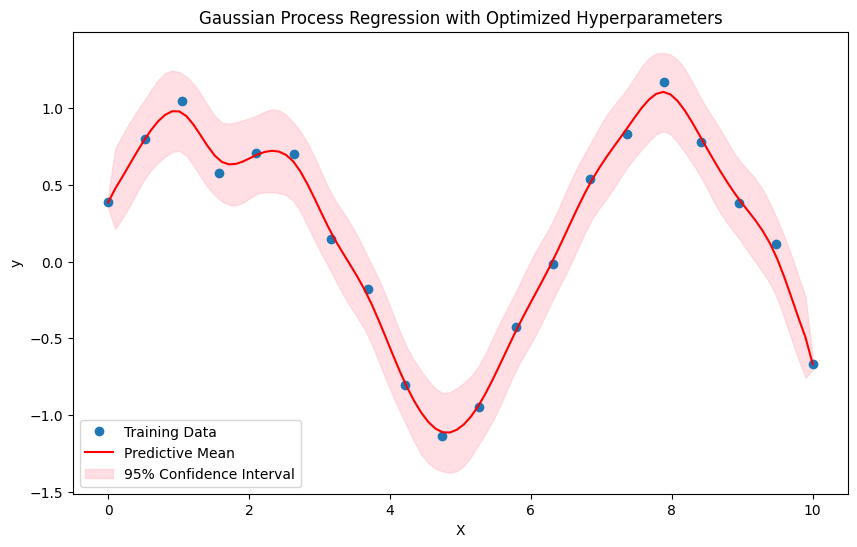

Optimized lengthscale: 1.8238824605941772
Optimized outputscale: 0.7473214864730835
Optimized noise: 0.011123047210276127


In [13]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# Generate synthetic data
torch.manual_seed(42)
X_train = torch.linspace(0, 10, 20).unsqueeze(1)  # Shape (20, 1)
y_train = torch.sin(X_train).squeeze() + 0.2 * torch.randn(X_train.size(0))  # Shape (20,)

# Define ModelConfig with initial parameters
config = ModelConfig(
    ard_num_dims=1,          # 1D input, no ARD
    kernel_type="matern32",   # Using Matern 3/2 kernel
    trained_params={"lengthscale": 1.0, "outputscale": 1.0, "noise": 0.1}
)

# Initialize CovFunc with config
cov_func = CovarianceFunction(config)

# Initialize GaussianProcess with cov_func and enable hyperparameter optimization
gp = tStudentProcess(cov_func, optimize=True, mprior=0.0)

# Fit the model to training data
gp.fit(X_train, y_train)

# Generate test data for prediction
X_test = torch.linspace(0, 10, 100).unsqueeze(1)

# Make predictions with the trained GP model
fmean, fcov = gp.predict(X_test, return_std=True)

# Plot the results
fmean = fmean.detach().numpy()
std_dev = fcov.detach().numpy() if isinstance(fcov, torch.Tensor) else np.sqrt(np.diag(fcov))

# Plot training data, predictive mean, and confidence intervals
plt.figure(figsize=(10, 6))
plt.plot(X_train.numpy(), y_train.numpy(), 'o', label='Training Data')
plt.plot(X_test.numpy(), fmean, 'r', label='Predictive Mean')
plt.fill_between(X_test.numpy().flatten(),
                 fmean - 1.96 * std_dev,
                 fmean + 1.96 * std_dev,
                 color='pink', alpha=0.5, label='95% Confidence Interval')
plt.xlabel("X")
plt.ylabel("y")
plt.legend()
plt.title("Gaussian Process Regression with Optimized Hyperparameters")
plt.show()

# Print optimized parameters
print("Optimized lengthscale:", gp.covfunc.kernel.base_kernel.lengthscale.item())
print("Optimized outputscale:", gp.covfunc.kernel.outputscale.item())
print("Optimized noise:", gp.covfunc.noise.item())
